### Importing required libraries

In [1]:
%matplotlib inline

from ipywidgets import FloatProgress
from IPython.display import display
from ipywidgets import *

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from sklearn import cross_validation
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.grid_search import GridSearchCV

### Utilities 

In [2]:
# Regression plot showing predicted gF scores vs original gF scores
def regression_plot(x,y,n,title):

    # fit a curve to the data using a least squares 1st order polynomial fit
    z = np.polyfit(x,y,1)

    p = np.poly1d(z)
    fit = p(x)

    # get the coordinates for the fit curve
    c_x = [np.min(x),np.max(x)]
    c_y = p(c_x)

    # predict y values of origional data using the fit
    p_y = z[0] * x + z[1]

    # calculate the y-error (residuals)
    y_err = y - p_y

    # create series of new test x-values to predict for
    p_x = np.arange(np.min(x),np.max(x)+1,1)

    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(x)         # mean of x
    DF = n - z.size                            # degrees of freedom
    t = stats.t.ppf(0.95,DF)           # used for CI and PI bands
    s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals

    #confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
    confs = t * np.sqrt((s_err/(n-2)) * (1.0/n + (np.power((p_x-mean_x),2)/(np.sum(np.power(x - mean_x,2))))))
    # now predict y based on test x-values
    p_y = z[0]*p_x+z[1]

    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)

    # set-up the plot
    plt.subplots(figsize=(8,8))
    plt.axes().set_aspect('equal')
    plt.xlabel('Original score')
    plt.ylabel('Predicted score')
    plt.title(title)

    # plot sample data
    plt.plot(x,y,'bo')

    # plot line of best fit
    plt.plot(c_x,c_y,'r-',label='Regression line')

    # plot confidence limits
    plt.plot(p_x,lower,'b--',label='Lower confidence limit (95%)')
    plt.plot(p_x,upper,'b--',label='Upper confidence limit (95%)')

    # set coordinate limits
    plt.xlim(4,25)
    plt.ylim(5,25)

    # configure legend
    plt.legend(loc=0)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=10)

    # add text
    rho,p = stats.pearsonr(np.ravel(y),x)
    s = 'r={:0.2f}\np={:1.4f}'.format(rho,p)
    plt.text(20, 7, s, fontsize=12)

    # show the plot
    plt.show()
    

### Importing data

In [15]:
#data = sio.loadmat('improved_preproc/rfMRI_REST1_HCP_Q2.mat')
data = sio.loadmat('improved_preproc/rfMRI_REST2_HCP_Q2.mat')
gF = np.ravel(data['PMAT24_A_CR'])
n_subj = len(gF)

### gF score distribution

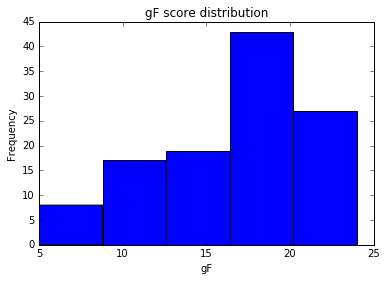

5

In [16]:
# gF score distribution 
n_bins = 5
def plot_hist(n_bins):
    plt.hist(gF, bins=n_bins)
    plt.title("gF score distribution")
    plt.xlabel("gF")
    plt.ylabel("Frequency")
    plt.show()
    return n_bins
    
interact(plot_hist, n_bins=(5,50,5)) 



In [17]:
# needed for stratified k-fold
hist, bin_limits = np.histogram(gF, n_bins)
bins = np.digitize(gF, bin_limits)
print(bin_limits)

[  5.    8.8  12.6  16.4  20.2  24. ]


### Building of input matrix
Starting from the connectivity matrices of each subject a #subjects x #edges matrix is built selecting for each subject the upper triangular matrix of the connectivity matrix (without the diagonal).

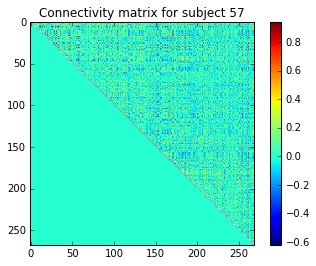

In [18]:
# choose dataset
#conn_mats = data['rest_1_mat']
conn_mats = data['rest_2_mat']

# build matrix n_subjects x n_edges
n_parcels = conn_mats.shape[0]
triu_idx = np.triu_indices(n_parcels,1)
n_edges = len(triu_idx[1]);

def plt_conn(subject):
    plt.imshow(np.triu(conn_mats[:,:,subject-1]))
    plt.colorbar()
    plt.title('Connectivity matrix for subject '+str(subject))

interact(plt_conn, subject=(1,n_subj),continuous_update=False)    
    
edges = np.zeros([n_subj,n_edges])

for subject in range(conn_mats.shape[-1]):
    edges[subject,] = conn_mats[:,:,subject][triu_idx]

### Training/Test Split
In order to build an holdout set that preserves the distribution of the gF scores across subjects, the scores are divided in bins and then a stratified split is performed.  

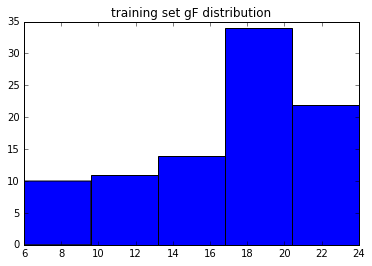

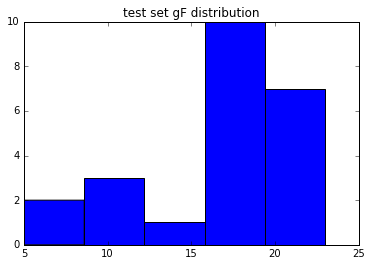

In [19]:
# Hold out set
X_train, X_test, y_train, y_test = cross_validation.train_test_split(edges,gF,test_size=0.2, random_state=42, stratify=bins)
plt.hist(y_train, bins=n_bins)
plt.title('training set gF distribution')
plt.show()
plt.hist(y_test, bins=n_bins)
plt.title('test set gF distribution')
plt.show()

### Test 1: SVR and RFE
Nested cross validation is used to select the best parameters for linear Support Vector Regression (SVR) in combination with Recursive Feature Elimination (RFE). The generalization ability of the model is assessed on the test set.

In [20]:
import warnings
warnings.simplefilter(action = "ignore", category = DeprecationWarning)

# params for SVR
param_grid = [{'C': val} for val in np.logspace(-6,0,10)]

# params for stratified k-fold
k=5
n_bins_cv = 5
hist_cv, bin_limits_cv = np.histogram(y_train, n_bins_cv)
bins_cv = np.digitize(y_train, bin_limits_cv)

svr = SVR(kernel='linear')

selector = RFECV(svr, step=round(0.10*edges.shape[1]), cv=5,verbose=True) #for now 5-fold NOT stratified, just a test

#loo = cross_validation.LeaveOneOut(len(train_index))

grids = GridSearchCV(selector, {'estimator_params': param_grid}, 
                     cv = cross_validation.StratifiedKFold(bins_cv,k),
                     verbose=True, n_jobs=-1)
grids.fit(X_train,y_train)
preds_1 = grids.predict(X_test)
print(grids.best_params_)

C:\Users\paola\Anaconda3\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.0min finished


{'estimator_params': {'C': 0.046415888336127725}}


In [9]:
print(selector.get_params())

{'estimator': SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False), 'estimator__gamma': 'auto', 'estimator__shrinking': True, 'estimator__C': 1.0, 'verbose': True, 'estimator__coef0': 0.0, 'estimator__max_iter': -1, 'estimator__degree': 3, 'estimator__verbose': False, 'estimator__epsilon': 0.1, 'estimator_params': None, 'scoring': None, 'estimator__tol': 0.001, 'estimator__kernel': 'linear', 'step': 3578, 'cv': 5, 'estimator__cache_size': 200}


In [11]:
results = {'svm_preds_improved_1':preds_1, 'score':y_test}
sio.savemat('res_svm_improved_1.mat', results)

In [21]:
results = {'svm_preds_improved_2':preds_1, 'score':y_test}
sio.savemat('res_svm_improved_2.mat', results)

### Results on Rest Session 1

In [13]:
print(preds_1)

[ 14.76427647  17.02236155  17.66704275  17.54604893  15.9979178
  15.39562189  15.35768292  15.09694639  16.27271421  18.52561467
  16.06392665  17.06800168  15.17311997  16.99914474  15.75612207
  16.74536889  14.96871326  16.47269538  15.5109023   15.25885709
  15.4710355   17.80851796  14.02837348  20.18313193]


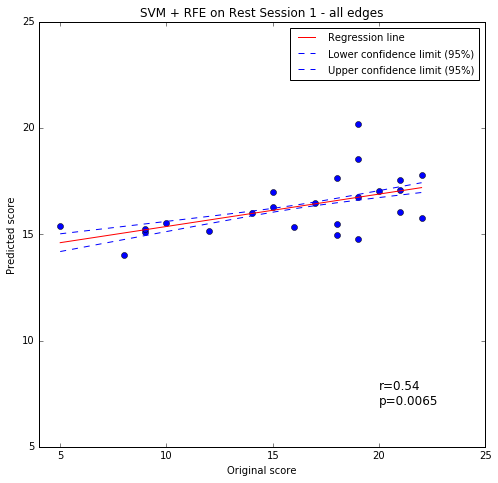

In [14]:
regression_plot(np.ravel(y_test),np.ravel(preds_1),n_subj,'SVM + RFE on Rest Session 1 - all edges') 

### Results on Rest Session 2

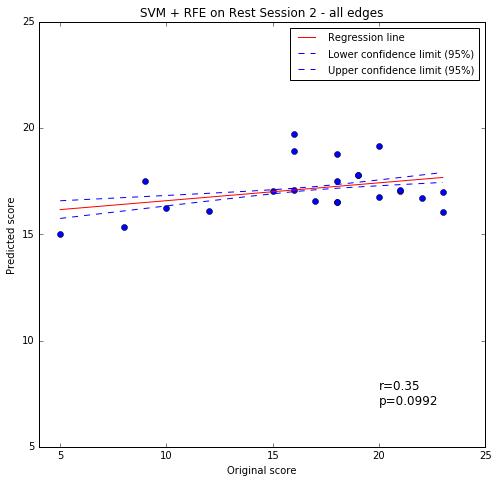

In [22]:
regression_plot(np.ravel(y_test),np.ravel(preds_1),n_subj,'SVM + RFE on Rest Session 2 - all edges') 

### Kernel map approximation with SDG 

In [23]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor

rbf_feature = RBFSampler(gamma=1,random_state=1)
data_rbf = rbf_feature.fit_transform(X_train)
sgd = SGDRegressor()
sgd.fit(data_rbf,y_train)
preds = sgd.predict(rbf_feature.transform(X_test))

In [24]:
print(data_rbf.shape)
print(preds)

(91, 100)
[ 12.23789593  12.16145695  12.1552689   12.09851484  12.34006191
  12.15649327  12.33351619  12.10923799  11.96530373  12.44367519
  12.31579704  12.31664026  12.18046328  12.01411072  12.23546078
  12.0775078   12.15219327  12.21606696  12.00804566  11.91384926
  11.9915094   12.215956    12.1654524 ]


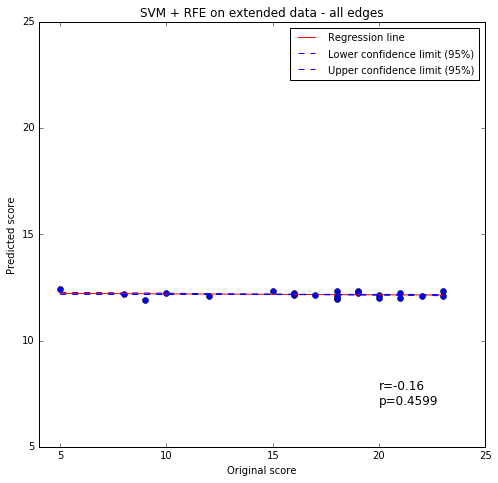

In [25]:
regression_plot(np.ravel(y_test),np.ravel(preds),n_subj,'SVM + RFE on extended data - all edges') 